# De la représentation au machine learning

Un exemple parmi d'autres

- une représentation numérique
- un modèle (supevisé ou non supervisé) en fonction de la tâche

In [4]:
#!pip install scipy

## Charger et nettoyer les données

In [2]:
import pandas as pd
df = pd.read_csv("../data/CSS_exact_openalex.csv")
df = df[~df["abstract"].isna()]
df["texte"] = df["title"] + " " + df["abstract"]
df.head()

,id,doi,title,display_name,relevance_score,publication_year,publication_date,language,type,type_crossref,...,locations.source,sustainable_development_goals.id,sustainable_development_goals.display_name,sustainable_development_goals.score,grants.funder,grants.funder_display_name,grants.award_id,counts_by_year.year,counts_by_year.cited_by_count,texte
0,https://openalex.org/W2159397589,https://doi.org/10.1126/science.1167742,Computational Social Science,Computational Social Science,1318.19960,2009,2009-02-06,en,article,journal-article,...,nan|nan|nan|nan|nan,https://metadata.un.org/sdg/10,Reduced inequalities,0.45,NaN,NaN,NaN,2025|2024|2023|2022|2021|2020|2019|2018|2017|2...,41|114|168|146|219|273|254|250|257|220|277|267...,"Computational Social Science 14,0642,033Metric..."
1,https://openalex.org/W2070907364,https://doi.org/10.1140/epjst/e2012-01697-8,Manifesto of computational social science,Manifesto of computational social science,488.98035,2012,2012-11-01,en,article,journal-article,...,nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan,https://metadata.un.org/sdg/3,Good health and well-being,0.47,NaN,NaN,NaN,2025|2024|2023|2022|2021|2020|2019|2018|2017|2...,4|22|41|35|47|33|33|38|24|32|36|30|19|4,Manifesto of computational social science The ...
3,https://openalex.org/W3022499311,https://doi.org/10.1146/annurev-soc-121919-054621,Computational Social Science and Sociology,Computational Social Science and Sociology,365.42535,2020,2020-04-28,en,article,journal-article,...,nan|nan|nan,https://metadata.un.org/sdg/10,Reduced inequalities,0.41,NaN,NaN,NaN,2025|2024|2023|2022|2021|2020,17|51|65|56|34|9,Computational Social Science and Sociology The...
7,https://openalex.org/W4389636360,https://doi.org/10.1162/coli_a_00502,Can Large Language Models Transform Computatio...,Can Large Language Models Transform Computatio...,297.86798,2023,2023-12-12,en,article,journal-article,...,nan|nan,NaN,NaN,NaN,NaN,NaN,NaN,2025|2024|2023,72|114|39,Can Large Language Models Transform Computatio...
9,https://openalex.org/W3124521395,https://doi.org/10.3389/fpsyg.2014.00668,On agent-based modeling and computational soci...,On agent-based modeling and computational soci...,275.27340,2014,2014-07-14,en,article,journal-article,...,nan|nan|nan|nan|nan,https://metadata.un.org/sdg/10,Reduced inequalities,0.47,NaN,NaN,NaN,2025|2024|2023|2022|2021|2020|2019|2018|2017|2...,4|17|16|13|18|22|10|13|12|8|7|2|3,On agent-based modeling and computational soci...


## Calculer une représentation tf-idf

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['texte'])

## Faire une classification hiérarchique ascendante


Calcule la distance entre chaque texte

In [4]:
Z = linkage(tfidf_matrix.toarray(), method='ward') 

Faire une représentation

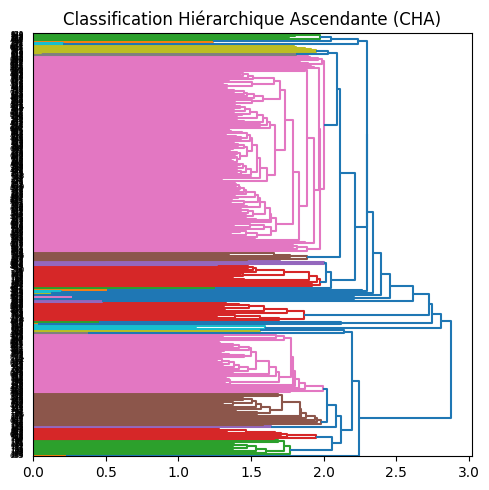

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
dendrogram(Z, orientation='right')
plt.title("Classification Hiérarchique Ascendante (CHA)")
plt.tight_layout()
plt.show()

Quels sont les questions les plus fréquentes ? Sont-elles posées sur les mêmes périodes ?

In [8]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5,  linkage='ward')
labels = cluster.fit_predict(tfidf_matrix.toarray())
df['cluster'] = labels

In [9]:
df['cluster'].value_counts()

cluster
0    439
1    207
4     30
2      7
3      7
Name: count, dtype: int64

Faire une représentation temporelle des clusters

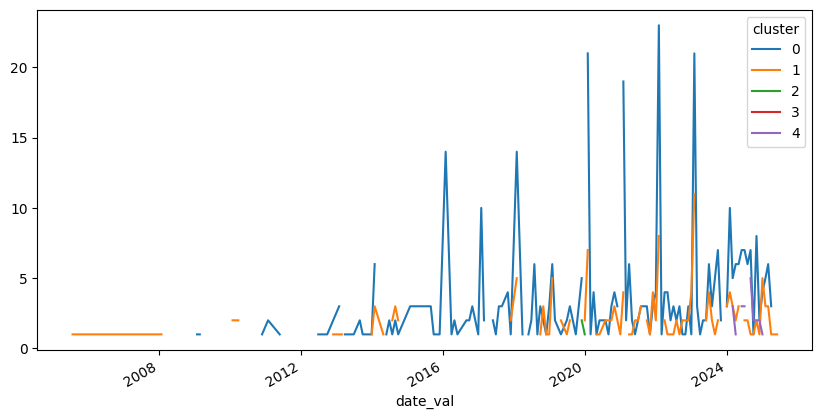

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
df['date_val'] = pd.to_datetime(df["publication_date"])
df.set_index('date_val').resample('ME')["cluster"].value_counts().unstack().plot(ax = ax);

### Quel est le contenu des clusters ?

Comment faire pour faire un résumé des clusters ? 

Une réponse : prendre la liste des mots les plus spécifiques

In [21]:
df_w = pd.DataFrame(tfidf_matrix.toarray(), 
                    columns=vectorizer.get_feature_names_out(), 
                    index=df.index) 

In [23]:
df_w[df["cluster"] == 1].max().sort_values()[-20:]

designer           0.483394
ictd               0.491694
phone              0.514894
representations    0.517614
consumer           0.526773
fertility          0.537212
entertainment      0.547879
css                0.550212
objectivity        0.553142
abcm               0.558443
engels             0.569934
disasters          0.571527
privacy            0.581020
regulation         0.586120
smart              0.601850
sustainability     0.619364
welfare            0.619496
mannheim           0.667790
informatics        0.672014
bioethics          0.700635
dtype: float64

On peut améliorer :

- le choix des clusters
- la manière de résumer un cluster
- la représentation des textes
- le découpage des textes

## D'autres embeddings

Par exemple, les modèles fasttext https://fasttext.cc/

In [ ]:
from gensim.models.fasttext import load_facebook_vectors
import numpy as np

In [ ]:
# Télécharger ce modèle depuis https://fasttext.cc/docs/en/crawl-vectors.html
model = load_facebook_vectors('../../../../../../Documents/models/cc.fr.300.bin')

In [ ]:
def document_vector(words):
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

# Matrice d'embeddings
X_embed = np.array([document_vector(doc) for doc in documents])
print(X_embed.shape)

Ou bien utiliser sbert https://sbert.net/ 

On voit apparaître de plus en plus de modèles

Ensuite la logique est la même...

## Empiler les traitements : BERTOPIC

Utiliser les différentes couches ensemble pour faire de la détection de thématiques : pipelines comme [BERTOPIC](https://maartengr.github.io/BERTopic/index.html)

![](../slides/img/bertopic.png)

[Faisons un test sur les données](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html)


In [ ]:
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import bertopic

nltk.download("stopwords")
french_stopwords = list(set(stopwords.words("french")))
vectorizer_model = CountVectorizer(stop_words=french_stopwords)
topic_model = bertopic.BERTopic(            language="french", 
            vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df['texte'])

In [ ]:
topic_model.get_topic_info()